# Classifiy single patients using the 2d method

This script can be used to apply the 2d method to a single case

### import modules

In [1]:
%matplotlib inline

In [2]:
import os
import fnmatch

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn import preprocessing, model_selection, metrics
from nilearn import plotting

import pickle

In [3]:
sns.set_style('white')
sns.set_context('poster')

### get absolute directory of project

In [4]:
# after converstion to .py, we can use __file__ to get the module folder
try:
    thisDir = os.path.realpath(__file__)
# in notebook form, we take the current working directory (we need to be in 'notebooks/' for this!)
except:
    thisDir = '.'
# convert relative path into absolute path, so this will work with notebooks and py modules
supDir = os.path.abspath(os.path.join(os.path.dirname(thisDir), '..'))

supDir

'/data/martin/language_lat'

### load labeler

In [5]:
myLabeler = pickle.load(open('%s/models/myLabeler.p'%supDir, 'rb'))

In [6]:
myLabeler.classes_

array(['bilateral', 'inconclusive', 'left', 'right'], dtype=object)

### settings for nice plots

here, we assign each group a consistent color:  
- left: red
- bilateral: green
- right: blue
- inconclusive: grey

Also, we use the seaborn color_palette to get in-between muted colors which are not so loud

In [7]:
# first, we put the colors in a dict, so there is a clear mapping of group to color
cDict = {}
for group, color in zip(myLabeler.classes_,
                        ['Greens', 'Greys', 'Reds', 'Blues']):
    cDict[group] = sns.color_palette(color, 4)[-2]
# then, we make a sorted list, in case we need this, which is ordered in the same way as our labeler object
cList = []
for group in myLabeler.classes_:
    cList.append(cDict[group])

right


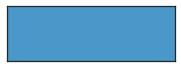

inconclusive


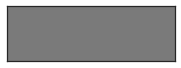

bilateral


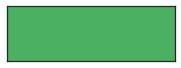

left


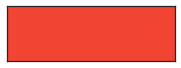

In [8]:
for c in cDict:
    print c
    sns.palplot(cDict[c])
    plt.show()

#### patient data

In [9]:
pName = 'pat0001_a'

In [10]:
csv = '%s/data/processed/csv/meanTable_%s.csv' % (supDir,pName)
nii = '%s/data/raw/nii/tMap_%s.nii' % (supDir,pName)

In [ ]:
meanPredDf = pd.read_csv(csv, index_col=[0, 1], header=0)
meanPredDf

In [ ]:
pVal = meanPredDf.loc['2d', ['L-R', 'L+R']].loc['full']
pVal

In [ ]:
pPred = meanPredDf.loc['2d', ['left', 'bilateral', 'right', 'inconclusive'
                              ]].loc['full']
pPred

### group data

In [14]:
my_train = pickle.load(open('%s/models/my_nest.p'%(supDir), 'rb'))
my_test = pickle.load(open('%s/models/my_test.p'%(supDir), 'rb'))
my_all = my_train + my_test

In [15]:
allAvg2dDf = pd.DataFrame()

for pGroup, pName in my_all:
    try:
        csv = '%s/data/processed/csv/meanTable_%s.csv' % (supDir, pName)

        pDf = pd.read_csv(csv, index_col=[0, 1], header=0)
        pDf = pDf.loc['2d', ['L-R', 'L+R']]
        pDf = pd.DataFrame(pDf.stack()).T
        pDf.index = [[pGroup], [pName]]
        allAvg2dDf = pd.concat([allAvg2dDf, pDf])
    except:
        pass

allAvg2dDf.sort_index(inplace=True)

In [ ]:
allAvg2dDf.tail()

store for later use in toolbox

In [17]:
allAvg2dDf.to_csv('%s/src/data/group_data.csv'%(supDir))

In [18]:
#allAvg2dDf = pd.read_csv('%s/data/group_data.csv'%supDir,index_col=[0,1],header=[0,1])

## make subplots

#### function to get probabilities formatted as plot title

In [19]:
def makeTitle(pPred):

    if 'inconclusive' in pPred.columns:
        myStr = ''
        for c, cs in zip(['left', 'bilateral', 'right', 'inconclusive'],
                         ['L', 'Bi', 'R', 'Inc']):
            myStr += cs + ' '
            myStr += str(round(pPred.fillna(0).mean(axis=0).loc[c], 2)) + '  '
    else:
        myStr = ''
        for c, cs in zip(['left', 'bilateral', 'right'], ['L', 'Bi', 'R']):
            myStr += cs + ' '
            myStr += str(round(pPred.fillna(0).mean(axis=0).loc[c], 2)) + '  '
        myStr += 'Inc 0.0  '

    return myStr[:-2]

### 2d space with values of patient as density map

In [20]:
def bigPlotMaker(ax, drop=False, allAvg2dDf=allAvg2dDf):

    dropStr = ['full', 'drop'][drop]

    # load the data
    thisAvg2dDf = allAvg2dDf.loc[:, dropStr]

    if drop:
        thisAvg2dDf.drop('inconclusive', inplace=True)
        # hard coded, to get the desired order
        groupList = ['left', 'right', 'bilateral']
    else:
        groupList = ['left', 'right', 'bilateral', 'inconclusive']

    for group in groupList:
        groupDf = thisAvg2dDf.loc[group]
        for pName in groupDf.index:
            thisDf = groupDf.loc[pName]
            ax.plot(
                thisDf['L-R'], thisDf['L+R'], 'o', c=cDict[group], alpha=0.4)

    ax.set_xlim(0.6, -0.6, -0.1)
    ax.set_ylim(-0.05, 1.15, 0.1)

    # prediction space
    a = pickle.load(open('%s/models/colors_2d_full.p'%supDir, 'rb'))
    b = pickle.load(open('%s/models/contours_2d_full.p'%supDir, 'rb'))

    ax.imshow(
        a, origin='lower', extent=(-0.9, 0.9, -0.1, 1.7), interpolation='none')
    ax.set_xlim(0.6, -0.6, -0.1)

    ax.contour(
        b,
        colors=('white'),
        levels=[0],
        alpha=0.9,
        origin='lower',
        extent=(-0.9, 0.9, -0.1, 1.7),
        antialiased=True,
        zorder=99)

    return ax

In [21]:
def singlePlot2d(meanPredDf, pColor, ax, allAvg2dDf=allAvg2dDf):

    # get column order right
    pVal = meanPredDf.loc['2d', ['L-R', 'L+R']].loc['full']

    ax = bigPlotMaker(ax, drop=False, allAvg2dDf=allAvg2dDf)

    ax.plot(
        pVal.loc['L-R'],
        pVal.loc['L+R'],
        'o',
        color=pColor,
        markeredgecolor='white',
        markeredgewidth=1,
        markersize=25,
        zorder=99,
        alpha=0.95)

    ax.set_title(
        'laterality=%.2f\nstrength=%.2f' % (pVal.loc['L-R'], pVal.loc['L+R']),
        fontsize=13)

    ax.set_xticks(np.arange(0.6, -0.61, -0.4))
    ax.set_yticks(np.arange(0.0, 1.5, 0.4))

    ax.set_xticklabels(np.arange(0.6, -0.61, -0.4).round(1), fontsize=12)
    ax.set_yticklabels(np.arange(0.0, 1.5, 0.4).round(1), fontsize=12)

    ax.set_xlabel('laterality (L-R)')
    ax.set_ylabel('strength (L+R)')

    return ax

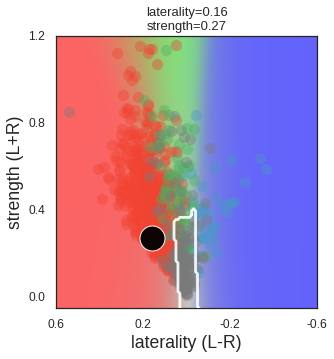

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax = singlePlot2d(meanPredDf, 'k', ax)
plt.show()

In [23]:
def makeDonut(meanPredDf, ax, cDict=cDict):

    pPred = meanPredDf.loc[
        '2d', ['left', 'bilateral', 'right', 'inconclusive']].loc['full']

    predVals = pPred.values
    predLabs = pPred.index

    ## donut plot visualization adapted from https://gist.github.com/krishnakummar/ad00d05311977732764f#file-donut-example-py

    ax.pie(
        predVals,
        #labels=predLabs,
        pctdistance=0.75,
        colors=[cDict[x] for x in pPred.index],
        autopct='%0.0f%%',
        shadow=False,
        textprops={'fontsize': 20})

    centre_circle = plt.Circle((0, 0), 0.55, fc='white')
    ax.add_artist(centre_circle)
    ax.set_aspect('equal')

    ax.set_title('Probabilities')
    return ax

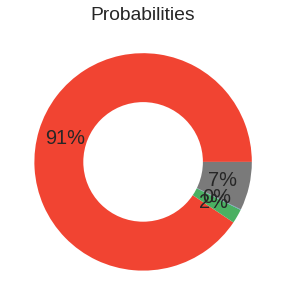

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax = makeDonut(meanPredDf, ax)
plt.show()

### both together

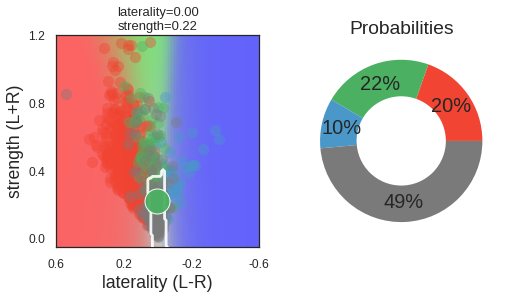

In [25]:
pGroup, pName = ('bilateral', 'pat0594_a')

csv = '%s/data/processed/csv/meanTable_%s.csv' % (supDir,pName)
meanPredDf = pd.read_csv(csv, index_col=[0, 1], header=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1 = singlePlot2d(meanPredDf, cDict[pGroup], ax1)
ax2 = makeDonut(meanPredDf, ax2)

plt.show()

### everything for one patient, including some brain slices

In [26]:
def makeP(pName, titleName=pName, supDir=supDir):

    ### place a single subject in the plot

    # make the plot
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3))

    ax1 = plt.subplot2grid((1, 14), (0, 0), colspan=2)

    ax1.text(0.05, 0.95, titleName, size=24)

    ax1 = plotting.plot_stat_map(
        '%s/data/raw/nii/tMap_%s.nii' % (supDir, pName),
        display_mode='y',
        cut_coords=([15]),
        colorbar=False,
        threshold=3,
        #vmax=10,
        axes=ax1,
        bg_img='%s/data/external/ch2better.nii.gz' % supDir,
        black_bg=False,
        draw_cross=False)

    ax2 = plt.subplot2grid((1, 14), (0, 2), colspan=5)
    ax2 = plotting.plot_stat_map(
        '%s/data/raw/nii/tMap_%s.nii' % (supDir, pName),
        display_mode='x',
        cut_coords=(-50, 50),
        colorbar=False,
        threshold=3,
        #vmax=10,
        axes=ax2,
        bg_img='%s/data/external/ch2better.nii.gz' % supDir,
        black_bg=False,
        draw_cross=False)

    csv = '%s/data/processed/csv/meanTable_%s.csv' % (supDir, pName)
    meanPredDf = pd.read_csv(csv, index_col=[0, 1], header=0)

    pGroup = meanPredDf.loc['2d', [
        'left', 'bilateral', 'right', 'inconclusive'
    ]].loc['full'].idxmax()

    ax3 = plt.subplot2grid((1, 14), (0, 8), colspan=3)
    ax3 = singlePlot2d(meanPredDf, cDict[pGroup], ax3)

    ax4 = plt.subplot2grid((1, 14), (0, 11), colspan=3)
    ax4 = makeDonut(meanPredDf, ax4)

    plt.close()

    return fig

In [27]:
#def makeP(pFolder, pName, supDir=supDir):
#
#    csv = os.path.join(pFolder,''.join(['meanTable_',pName,'.csv']))
#    nii = os.path.join(pFolder,''.join(['tMap_',pName,'.nii']))
#
#    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3))
#
#    ax1 = plt.subplot2grid((1, 14), (0, 0), colspan=2)
#
#    ax1.text(0.05, 0.95, pName, size=24)
#
#    ax1 = plotting.plot_stat_map(
#        nii,
#        display_mode='y',
#        cut_coords=([15]),
#        colorbar=False,
#        threshold=3,
#        axes=ax1,
#        bg_img='%s/data/external/ch2better.nii.gz'%supDir,
#        black_bg=False,
#        draw_cross=False)
#
#    ax2 = plt.subplot2grid((1, 14), (0, 2), colspan=5)
#    ax2 = plotting.plot_stat_map(
#        nii,
#        display_mode='x',
#        cut_coords=(-50, 50),
#        colorbar=False,
#        threshold=3,
#        axes=ax2,
#        bg_img='%s/data/external/ch2better.nii.gz'%supDir,
#        black_bg=False,
#        draw_cross=False)
#
#    meanPredDf = pd.read_csv(csv, index_col=[0, 1], header=0)
#
#    pGroup = meanPredDf.loc['2d', [
#        'left', 'bilateral', 'right', 'inconclusive'
#    ]].loc['full'].idxmax()
#
#    ax3 = plt.subplot2grid((1, 14), (0, 8), colspan=3)
#    ax3 = singlePlot2d(meanPredDf, cDict[pGroup], ax3)
#
#    ax4 = plt.subplot2grid((1, 14), (0, 11), colspan=3)
#    ax4 = makeDonut(meanPredDf, ax4)
#
#    figName = '%s/fig_%s.png'%(pFolder,pName)
#    plt.savefig(figName, bbox_inches='tight', dpi=300)
#
#    return figName

In [28]:
thisFig = makeP(pName)

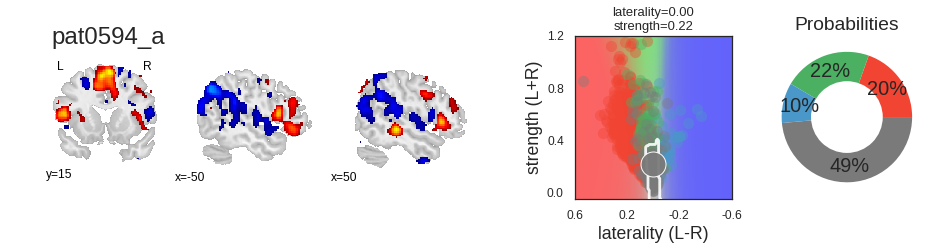

In [29]:
thisFig

### plot probability for whole parameter space

#### function to get index as numbers after loading from csv

In [30]:
def changeIdx(df):

    idx1 = df.index.get_level_values(0).astype(int)
    idx2 = df.index.get_level_values(1).astype(float)

    mIdx = pd.MultiIndex.from_arrays([idx2, idx1])

    df.index = mIdx
    df.sort_index(axis=0,inplace=True)

    return df

### read data with raw probabilities for each class

In [31]:
predDf = pd.read_csv(
    '%s/data/processed/csv/predictions_%s_2d_full.csv'%(supDir,pName),
    index_col=[0])
predDf.index = pd.MultiIndex.from_tuples(
    list([x.split('_') for x in predDf.index]))
predDf = changeIdx(predDf)

### make plot

In [32]:
fig = plt.figure(figsize=(16, 6))
for i, c in enumerate(['left', 'bilateral', 'right', 'inconclusive']):
    ax = plt.subplot(1, predDf.columns.shape[-1], i + 1)
    thisDf = predDf.loc[:, [c]].unstack()[c].T

    cbarCol = 'hot'

    if i == 3:
        sns.heatmap(
            thisDf,
            cmap=cbarCol,
            vmin=0,
            vmax=1,
            axes=ax,
            cbar_kws={"label": "probability of class"})
    else:
        sns.heatmap(
            thisDf,
            cmap=cbarCol,
            cbar_kws={"ticks": []},
            vmin=0,
            vmax=1,
            axes=ax)
    my_cols = thisDf.columns
    ax.set_xticks(range(len(my_cols))[::3])
    ax.set_xticklabels(my_cols[::3])
    if i > 0:
        ax.set_yticks([])
    else:
        ax.set_ylabel('small <- ROI percentile -> large')
    ax.set_title(c)

    ax.set_xlabel('t cutoff')

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=360) # hack

plt.tight_layout()
plt.close()

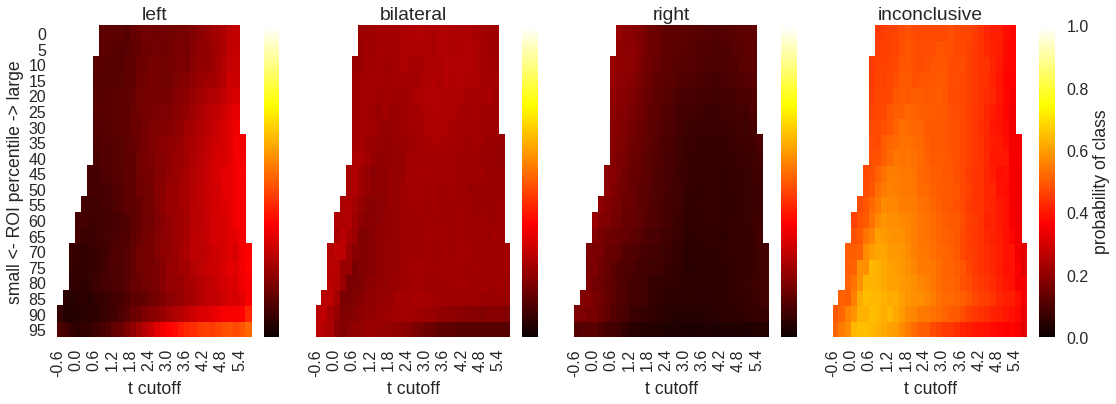

In [33]:
fig

In [34]:
#def makePProb(pFolder, pName, supDir=supDir):
#
#    csv = os.path.join(pFolder,
#                       ''.join(['predictions_', pName, '_2d_full.csv']))
#
#    predDf = pd.read_csv(csv, index_col=[0])
#    predDf.index = pd.MultiIndex.from_tuples(
#        list([x.split('_') for x in predDf.index]))
#
#    predDf = changeIdx(predDf)
#
#    fig = plt.figure(figsize=(16, 6))
#    for i, c in enumerate(['left', 'bilateral', 'right', 'inconclusive']):
#        ax = plt.subplot(1, predDf.columns.shape[-1], i + 1)
#        thisDf = predDf.loc[:, [c]].unstack()[c].T
#
#        cbarCol = 'hot'
#
#        if i == 3:
#            sns.heatmap(
#                thisDf,
#                cmap=cbarCol,
#                vmin=0,
#                vmax=1,
#                axes=ax,
#                cbar_kws={"label": "probability of class"})
#        else:
#            sns.heatmap(
#                thisDf,
#                cmap=cbarCol,
#                cbar_kws={"ticks": []},
#                vmin=0,
#                vmax=1,
#                axes=ax)
#        my_cols = thisDf.columns
#        ax.set_xticks(range(len(my_cols))[::3])
#        ax.set_xticklabels(my_cols[::3])
#        if i > 0:
#            ax.set_yticks([])
#        else:
#            ax.set_ylabel('small <- ROI percentile -> large')
#        ax.set_title(c)
#
#        ax.set_xlabel('t cutoff')
#
#        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#        ax.set_yticklabels(ax.get_yticklabels(), rotation=360)
#
#    plt.tight_layout()
#
#    figName = '%s/figProb_%s.png' % (pFolder, pName)
#    plt.savefig(figName, bbox_inches='tight', dpi=300)
#
#    return figName

In [35]:
sns.set_style('dark')

In [36]:
fig = plt.figure(figsize=(16, 60))

for i, (pGroup, pName, titleName) in enumerate(
    [('bilateral', 'pat0594_a', 'Patient A, first fMRI'),
     ('bilateral', 'pat0594_b', 'Patient A, second fMRI (one year later)'),
     ('inconclusive', 'pat0692_a', 'Patient B,first fMRI'),
     ('right', 'pat0692_b', 'Patient B, second fMRI (later the same day)')]):

    thisFig = makeP(pName, titleName=titleName)

    # dumb workaround to get the figures plotted which
    # are saved as variables
    imName = '%s/temp/tempfig.png' % supDir
    thisFig.savefig(imName, bbox_inches='tight', dpi=300)

    yPos = (4 * 0.08) - (i * 0.08)
    ax = fig.add_axes([0, yPos, 1, 1])

    ax.imshow(plt.imread(imName))

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])

plt.close()

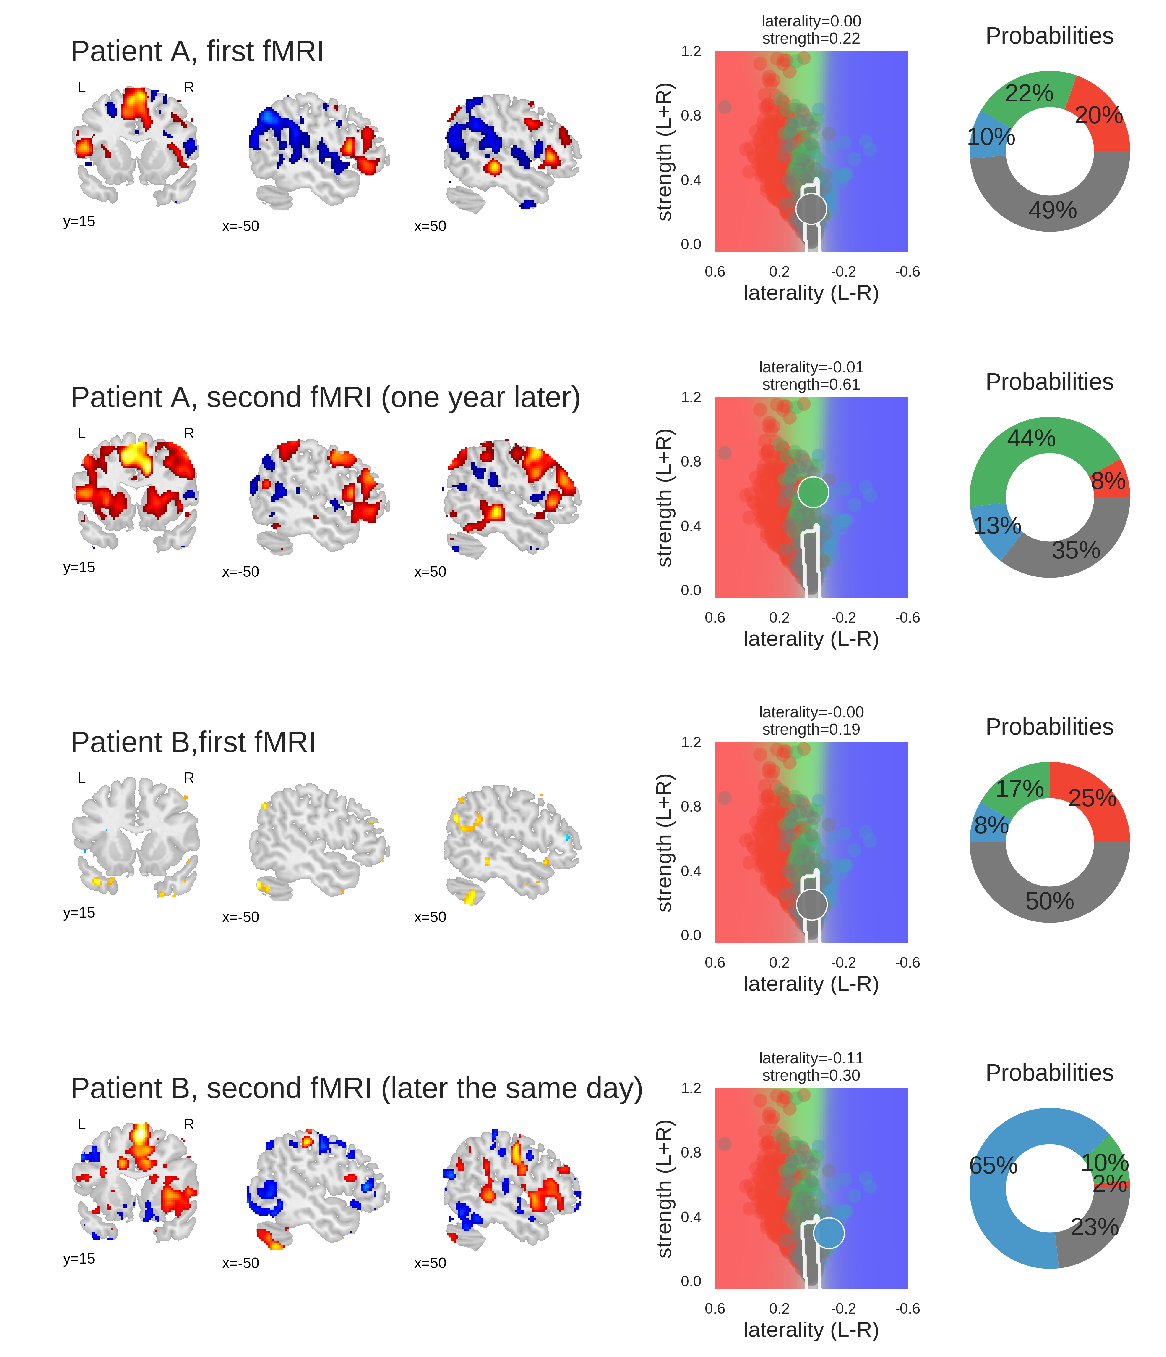

In [37]:
fig

In [38]:
fig.savefig(
    '%s/reports/figures/12-single-case-examples.png' % supDir,
    dpi=300,
    bbox_inches='tight')